In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

### NEF Network

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

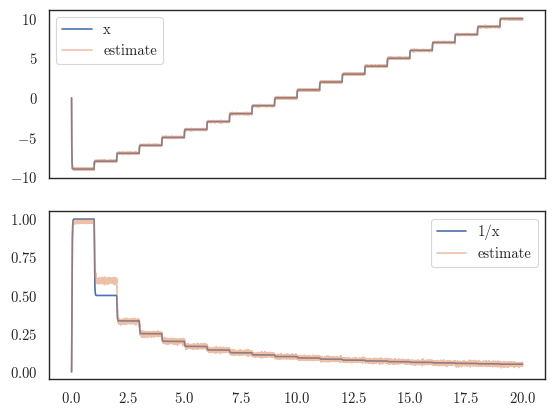

In [25]:
func_inverse = lambda x: 1/(x+10)

with nengo.Network(seed=0) as net:
    inputs = nengo.Node(lambda t: int(t+1)-10)
    pre = nengo.Ensemble(1000, 1, radius=12)  # , max_rates=nengo.dists.Uniform(150, 200), neuron_type=nengo.LIF(tau_ref=0.005))
    post = nengo.Ensemble(1000, 1, radius=0.9)  # , max_rates=nengo.dists.Uniform(200, 300), neuron_type=nengo.LIF(tau_ref=0.002))
    perfect = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
    nengo.Connection(inputs, pre, synapse=None)
    nengo.Connection(pre, post, synapse=0.02, function=func_inverse)
    nengo.Connection(inputs, perfect, synapse=0.01, function=func_inverse)
    p_inputs = nengo.Probe(inputs, synapse=0.01)
    p_pre = nengo.Probe(pre, synapse=0.01)
    p_post = nengo.Probe(post, synapse=0.01)
    p_correct = nengo.Probe(perfect, synapse=0.01)

with nengo.Simulator(net) as sim:
    sim.run(20)

fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(sim.trange(), sim.data[p_inputs], label='x')
axes[0].plot(sim.trange(), sim.data[p_pre], label='estimate', alpha=0.5)
axes[1].plot(sim.trange(), sim.data[p_correct], label='1/x')
axes[1].plot(sim.trange(), sim.data[p_post], label='estimate', alpha=0.5)
axes[0].legend()
axes[1].legend()
plt.show()
fig.savefig("plots/1_over_x.jpg")

### Noise analysis

In [12]:
def mean_history(obs):
    output = []
    for o in range(len(obs)):
        output.append(np.mean(obs[:o+1]))
    return np.array(output)

In [11]:
def weighted_error(obs, noise='none', sigma=0, seed=0):
    output = []
    value = 0
    rng = np.random.RandomState(seed=seed)
    for o in range(len(obs)):
        weight = 1/(o+1)
        if noise=='percent':
            random = rng.normal(0, sigma*weight)
            weight += random
        elif noise=='constant':
            random = rng.normal(0, sigma)
            weight += random
        error = obs[o] - value
        value += weight * error
        output.append(value)
    return np.array(output)

In [30]:
human = pd.read_pickle("data/human.pkl")
sigmas = np.arange(0, 0.1, 0.01)

dfs = []
dfs2 = []
columns = ['sid', 'trial', 'noise', 'sigma', 'final error']
columns2 = ['sid', 'trial', 'noise', 'sigma', 'obs', 'cumulative error']
for noise in ['percent', 'constant']:
    for sigma in sigmas:
        print(noise, sigma)
        for sid in human['sid'].unique():
            for trial in human.query("sid==@sid")['trial'].unique():
                obs = human.query("sid==@sid & trial==@trial")['color'].to_numpy()
                perfect = mean_history(obs)
                prediction = weighted_error(obs, noise, sigma)
                prediction = np.clip(prediction, -1, 1)
                delta = np.cumsum(np.abs(perfect - prediction))
                dfs.append(pd.DataFrame([[sid, trial, noise, sigma, delta[-1]]], columns=columns))
                for o in range(len(obs)):
                    dfs2.append(pd.DataFrame([[sid, trial, noise, sigma, o, delta[o]]], columns=columns2))

final_errors = pd.concat(dfs, ignore_index=True)
cumulative_errors = pd.concat(dfs2, ignore_index=True)

percent 0.0
percent 0.01
percent 0.02
percent 0.03
percent 0.04
percent 0.05
percent 0.06
percent 0.07
percent 0.08
percent 0.09
constant 0.0
constant 0.01
constant 0.02
constant 0.03
constant 0.04
constant 0.05
constant 0.06
constant 0.07
constant 0.08
constant 0.09


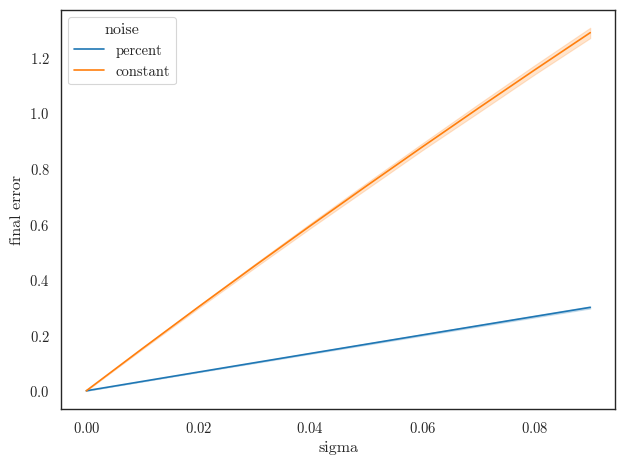

In [31]:
fig, ax = plt.subplots()
sns.lineplot(data=final_errors, x='sigma', y='final error', hue='noise', ax=ax, palette=palette[:2])
plt.tight_layout()
plt.show()

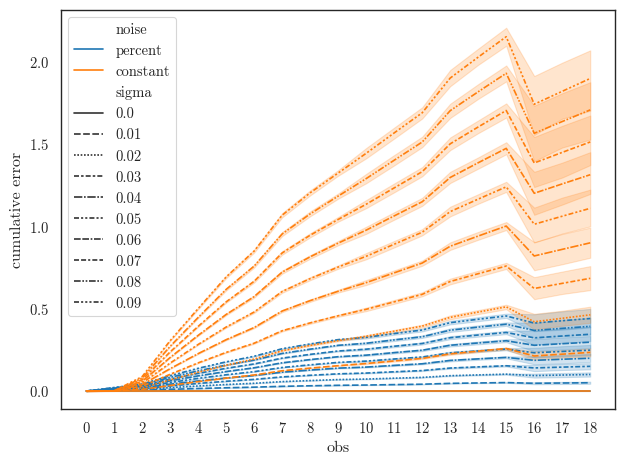

In [36]:
fig, ax = plt.subplots()
sns.lineplot(data=cumulative_errors, x='obs', y='cumulative error', hue='noise', style='sigma', ax=ax, palette=palette[:2])
ax.set(xticks=np.arange(0,19,1))
plt.tight_layout()
plt.show()

### Comparison to human data

In [37]:
human = pd.read_pickle("data/human.pkl")
noise = pd.read_pickle("data/DGn_jan16b_noise.pkl")

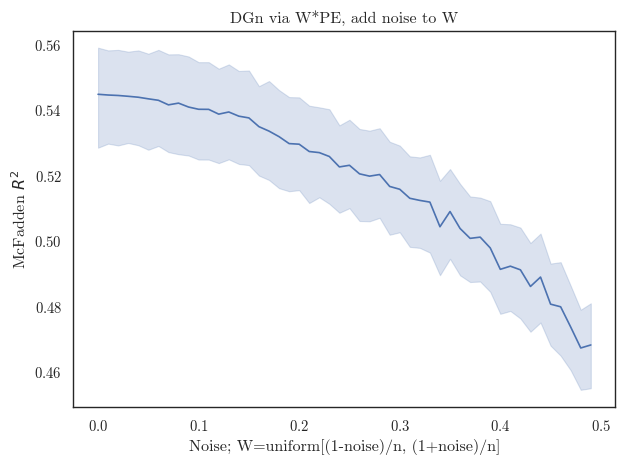

In [46]:
fig, ax = plt.subplots()
sns.lineplot(data=noise, x='sigma', y='McFadden R2', ax=ax)
ax.set(xlabel="Noise; W=uniform[(1-noise)/n, (1+noise)/n]", ylabel=r"McFadden $R^2$", title="DGn via W*PE, add noise to W")
plt.tight_layout()
plt.show()
fig.savefig("plots/DGn_with_W_noise_performance.jpg", dpi=600)

In [47]:
noise

,type,sid,sigma,NLL,McFadden R2
0,DGn,1,0.00,48.207068,0.565324
1,DGn,1,0.01,48.328056,0.564233
2,DGn,1,0.02,48.441245,0.563213
3,DGn,1,0.03,47.993738,0.567248
4,DGn,1,0.04,48.337093,0.564152
...,...,...,...,...,...
10445,DGn,224,0.45,71.068589,0.359186
10446,DGn,224,0.46,74.098706,0.331864
10447,DGn,224,0.47,69.677254,0.371731
10448,DGn,224,0.48,72.706628,0.344416


In [57]:
human2 = pd.read_pickle("data/human2.pkl")
dfs = []
columns = ['sid', 'trial', 'stage', 'sum private', 'action', 'correct', 'abs sum private']
for sid in human2['sid'].unique():
    corrects = []
    for trial in human2.query("sid==@sid")['trial'].unique():
        sum_private = human2.query("sid==@sid & trial==@trial")['sum private'].unique()[0]
        for stage in range(4):
            action = human2.query("sid==@sid & trial==@trial & stage==@stage")['action'].to_numpy()[-1]
            correct = 1 if np.sign(action)==np.sign(sum_private) else 0
            dfs.append(pd.DataFrame([[sid, trial, stage, sum_private, action, correct, np.abs(sum_private)]], columns=columns))
human3 = pd.concat(dfs, ignore_index=True)

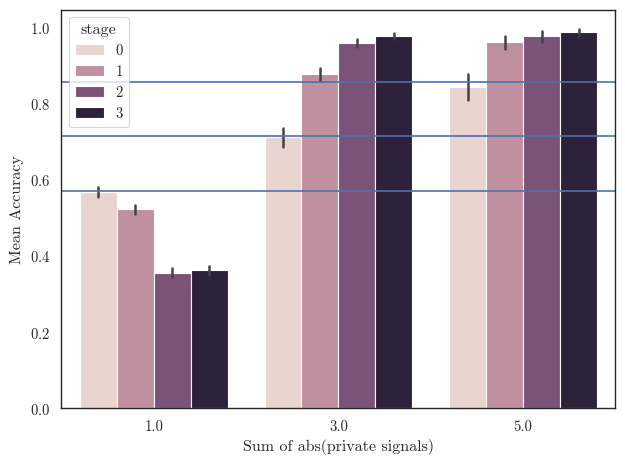

In [62]:
fig, ax = plt.subplots()
sns.barplot(data=human3, x='abs sum private', y='correct', hue='stage')
ax.axhline(4/7)
ax.axhline(5/7)
ax.axhline(6/7)
ax.set(ylabel='Mean Accuracy', xlabel='Sum of abs(private signals)')
plt.tight_layout()
fig.savefig("plots/human_accuracy.jpg", dpi=600)

In [8]:
sigmas = pd.read_pickle("data/DGn_jan17_noise.pkl")

,type,sid,sigma,NLL,McFadden R2,mean accuracy
0,DGn,1,0.000,48.207068,0.565324,0.500
1,DGn,1,0.025,48.519645,0.562506,0.500
2,DGn,1,0.050,48.841132,0.559607,0.500
3,DGn,1,0.075,47.797009,0.569022,0.500
4,DGn,1,0.100,48.731972,0.560591,0.475
...,...,...,...,...,...,...
8564,DGn,224,0.900,88.795896,0.199341,0.450
8565,DGn,224,0.925,89.354582,0.194304,0.450
8566,DGn,224,0.950,92.774150,0.163470,0.450
8567,DGn,224,0.975,88.833340,0.199004,0.450


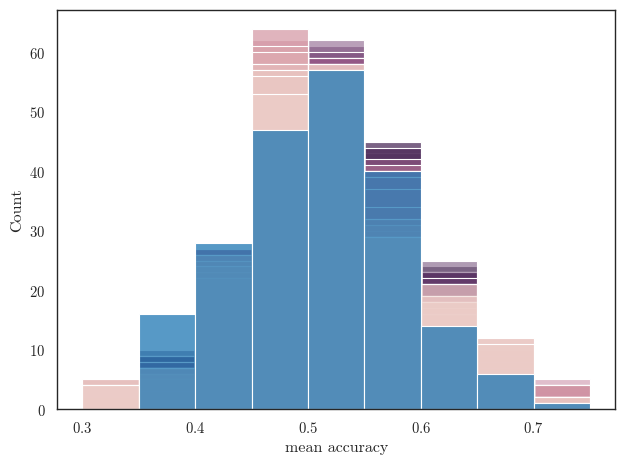

In [36]:
bins = np.arange(0.3, 0.8, 0.05)
fig, ax = plt.subplots()
sns.histplot(data=sigmas, x='mean accuracy', hue='sigma', ax=ax, bins=bins)
sns.histplot(np.array(accuracies), ax=ax, color=palette[0], bins=bins)
ax.get_legend().remove()
plt.tight_layout()
plt.show()
fig.savefig("plots/accuracy_histogram.jpg")

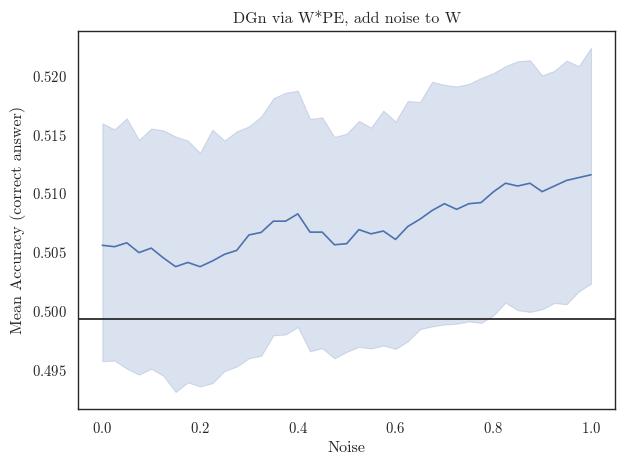

In [39]:
fig, ax = plt.subplots()
sns.lineplot(data=sigmas, x='sigma', y='mean accuracy', ax=ax)
ax.axhline(np.mean(accuracies), color='k', label='human')
ax.set(xlabel="Noise", ylabel="Mean Accuracy (correct answer)", title="DGn via W*PE, add noise to W")
plt.tight_layout()
plt.show()
fig.savefig("plots/DGn_with_W_noise_accuracy.jpg", dpi=600)

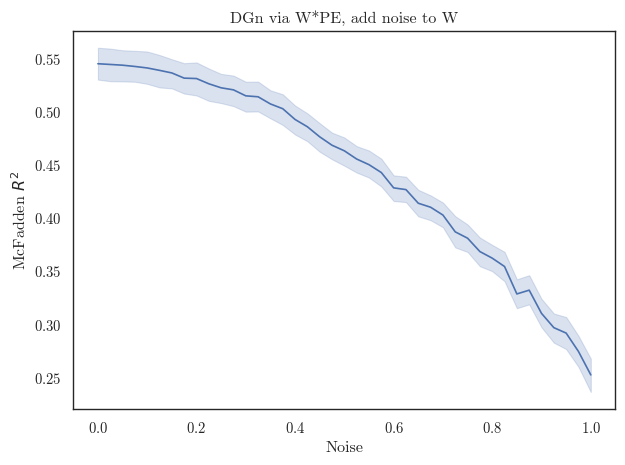

In [21]:
fig, ax = plt.subplots()
sns.lineplot(data=sigmas, x='sigma', y='McFadden R2', ax=ax)
ax.set(xlabel="Noise", ylabel=r"McFadden $R^2$", title="DGn via W*PE, add noise to W")
plt.tight_layout()
plt.show()
fig.savefig("plots/DGn_with_W_noise_performance.jpg", dpi=600)

In [20]:
sigmas.query("sid==5")

,type,sid,sigma,NLL,McFadden R2,mean accuracy
164,DGn,5,0.000,70.969725,0.360077,0.525
165,DGn,5,0.025,70.964456,0.360125,0.525
166,DGn,5,0.050,70.832082,0.361318,0.500
167,DGn,5,0.075,70.928595,0.360448,0.500
168,DGn,5,0.100,70.420070,0.365033,0.500
169,DGn,5,0.125,71.098223,0.358918,0.500
170,DGn,5,0.150,70.651076,0.362950,0.500
171,DGn,5,0.175,69.471508,0.373586,0.500
172,DGn,5,0.200,69.769182,0.370902,0.500
173,DGn,5,0.225,70.469651,0.364586,0.500
